In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import matplotlib.colors as colors
import matplotlib as mpl
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import cartopy.feature as cfeature 
import cartopy.mpl.ticker as cticker 
import imageio
import os
import cupy
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from xgboost import plot_importance, plot_tree

In [2]:
import warnings
warnings.filterwarnings(action='once')
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Number of CUDA devices: {torch.cuda.device_count()}")

if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")

CUDA available: True
Number of CUDA devices: 1
Device 0: Tesla V100-SXM2-32GB


In [4]:
from dask.distributed import Client
client = Client(processes=False)

In [5]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 1
Total threads: 12,Total memory: 95.00 GiB
Status: running,Using processes: False
Comm: inproc://10.6.10.18/909904/1,Workers: 1
Dashboard: /proxy/8787/status,Total threads: 12
Started: Just now,Total memory: 95.00 GiB
Comm: inproc://10.6.10.18/909904/4,Total threads: 12
Dashboard: /proxy/33177/status,Memory: 95.00 GiB
Nanny: None,


In [6]:
matplotlib.rcParams['font.family'] = 'Times New Roman'


In [7]:
print(xgb.__version__)

2.1.3


# Read the data (the csv files that contains u850 v850 q850 and total precipitation)

In [8]:
total_data_dir = "/g/data/v46/yz7014/xgbmodel_sst_q_u_v/pd_u850_v850_q850_tp.csv"
total_data = pd.read_csv(total_data_dir)
total_data

,Unnamed: 0,longitude,latitude,u,v,q,sst,tp,day,year
0,0,150.0,-15.0,-1.431877,0.406518,0.014361,302.392775,0.021885,0,1998
1,1,150.0,-15.0,8.473993,3.889071,0.014225,302.120615,0.026688,1,1998
2,2,150.0,-15.0,9.701285,12.309663,0.013478,301.808543,0.015503,2,1998
3,3,150.0,-15.0,6.530669,9.872260,0.014280,301.575891,0.014156,3,1998
4,4,150.0,-15.0,5.889120,5.809094,0.013236,301.472827,0.006033,4,1998
...,...,...,...,...,...,...,...,...,...,...
15531826,15531826,170.0,-20.0,-0.501214,-5.505222,0.012862,301.758803,0.013507,9126,2022
15531827,15531827,170.0,-20.0,3.435006,-5.006035,0.013322,301.785924,0.060589,9127,2022
15531828,15531828,170.0,-20.0,7.359803,-8.244948,0.014317,301.670985,0.067293,9128,2022
15531829,15531829,170.0,-20.0,11.160101,-5.078793,0.010328,301.260967,0.001096,9129,2022


In [9]:
total_data = total_data.drop(columns = 'Unnamed: 0')
total_data

,longitude,latitude,u,v,q,sst,tp,day,year
0,150.0,-15.0,-1.431877,0.406518,0.014361,302.392775,0.021885,0,1998
1,150.0,-15.0,8.473993,3.889071,0.014225,302.120615,0.026688,1,1998
2,150.0,-15.0,9.701285,12.309663,0.013478,301.808543,0.015503,2,1998
3,150.0,-15.0,6.530669,9.872260,0.014280,301.575891,0.014156,3,1998
4,150.0,-15.0,5.889120,5.809094,0.013236,301.472827,0.006033,4,1998
...,...,...,...,...,...,...,...,...,...
15531826,170.0,-20.0,-0.501214,-5.505222,0.012862,301.758803,0.013507,9126,2022
15531827,170.0,-20.0,3.435006,-5.006035,0.013322,301.785924,0.060589,9127,2022
15531828,170.0,-20.0,7.359803,-8.244948,0.014317,301.670985,0.067293,9128,2022
15531829,170.0,-20.0,11.160101,-5.078793,0.010328,301.260967,0.001096,9129,2022


# Split the training and testing data
- Randomly split the training and testing data by year
- Delete NaN data

In [10]:
def training_testing_split(data):
    """
    Split the data into training and testing data
    
    Parameters:
    -----------
    data: pd dataframe
        The data to be split
    
    return: pd dataframe, pd dataframe
        The training and testing data
    """
    years = list(range(1998, 2022))
    shuffled_years = pd.Series(years).sample(frac=1).tolist()
    training_years = shuffled_years[:18]
    testing_years = shuffled_years[18:]

    training_data = data[data['year'].isin(training_years)].dropna()
    testing_data = data[data['year'].isin(testing_years)].dropna()

    training_X = training_data.drop(columns = ['tp', 'year'], axis = 1)
    training_y = training_data['tp']
    testing_X = testing_data.drop(columns = ['tp', 'year'], axis = 1)
    testing_y = testing_data['tp']
    print('Training years: ', training_years)
    print('Testing years: ', testing_years)
    return training_X, testing_X, training_y, testing_y, training_years, testing_years

# XGBoost build

In [11]:
def run_model(xgb_reg, training_X, testing_X, training_y, testing_y):
    """
    Train the model and return the model and the prediction
    
    Parameters:
    -----------
    xgb_reg: xgboost model
        The xgboost model to be trained
    training_X: pd dataframe
        The training data
    testing_X: pd dataframe
        The testing data
    training_y: pd dataframe
        The training label
    testing_y: pd dataframe
        The testing label
    
    return: xgboost model, np array
        The trained model and the prediction
    """
    
    
    xgb_model = xgb_reg.fit(training_X, training_y)
    y_pred = xgb_reg.predict(testing_X)
    rmse = np.sqrt(mean_squared_error(testing_y, y_pred))
    r2 = r2_score(testing_y, y_pred)
    print('RMSE: ', rmse)
    print('R^2: ', r2)

    return y_pred, xgb_model

In [12]:
params = {
    'learning_rate': 0.01,
    'n_estimators': 650,
    'max_depth': 15,
    'min_child_weight': 10,
    'subsample': 0.55,
    'gamma': 0.1,
    'colsample_bytree': 1,
    'objective': 'reg:squarederror',
    'tree_method': 'hist',
    'device' : 'cuda'
}

In [13]:
training_X, testing_X, training_y, testing_y, training_years, testing_years = training_testing_split(total_data)

Training years:  [2001, 2004, 1999, 2006, 2017, 1998, 2013, 2002, 2010, 2019, 2009, 2000, 2011, 2007, 2016, 2018, 2021, 2003]
Testing years:  [2015, 2012, 2020, 2014, 2008, 2005]


In [14]:

xgb_reg = xgb.XGBRegressor(**params, seed = 42)
y_pred, xgb_model = run_model(xgb_reg, training_X, testing_X, training_y, testing_y)

/g/data/jk72/yz7014/stf/testvenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:19:10] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


RMSE:  0.008015310277790755
R^2:  0.35875265484074603


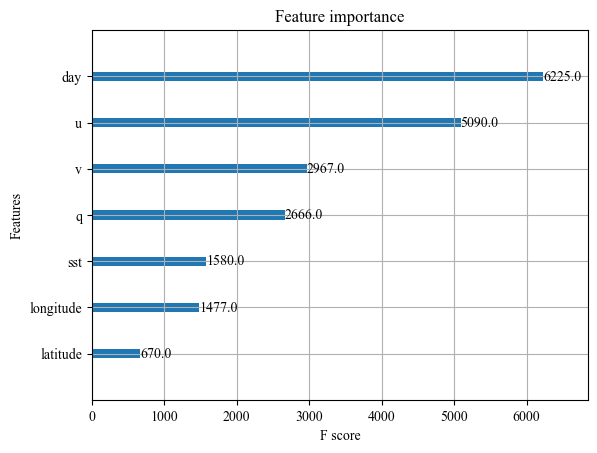

In [15]:
plot_importance(xgb_model)
plt.show()

In [16]:
params = {
    'learning_rate': 0.01,
    'n_estimators': 700,
    'max_depth': 15,
    'min_child_weight': 10,
    'subsample': 0.55,
    'gamma': 0.01,
    'colsample_bytree': 1,
    'objective': 'reg:squarederror',
}

In [17]:
xgb_reg = xgb.XGBRegressor(**params, seed = 42)

# Tuning


## Try to use Bayesian optimization to tuning the model

In [18]:
def bayesian_tuning(X_train, y_train, X_test, y_test, param_test, alg):
    """
    Optimize XGBoost hyperparameters using Bayesian Optimization with GPU support.
    """
    # Add GPU parameters to all models created during tuning
    param_space = param_test.copy()  # Make a copy to avoid modifying the original
    
    # Define fixed GPU parameters
    gpu_params = {
        'tree_method': 'hist',
        'device': 'cuda'
    }
    
    # Update the base model with GPU parameters
    model = alg
    model.set_params(**gpu_params)
    
    optimizer = BayesSearchCV(
        model,
        param_space,
        n_iter = 20,
        cv = 4,
        verbose = 1,
        n_jobs = 1
    )

    optimizer.fit(X_train, y_train)
    
    best_params = optimizer.best_params_.copy()
    best_params.update(gpu_params)
    
    # Create the best model with GPU parameters
    best_model = xgb.XGBRegressor(**best_params, random_state=42)
    best_model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = best_model.predict(X_test)
    test_score = mean_squared_error(y_test, y_pred, squared=False)
    
    results = {
        'best_params': best_params,
        'rmse': test_score,
        'best_model': best_model,
        'best_score_cv': optimizer.best_score_,
        'test_accuracy': 1 - test_score/np.mean(y_test)  # Approximate accuracy measure for regression
    }
    
    return results
    
    

In [19]:
param_test = {
    'n_estimators': Integer(450, 800),
    'learning_rate': Real(0.01, 0.1),
    'max_depth': Integer(10,20),
    'gamma': Real(0, 0.3),
    'min_child_weight': Integer(12,18)
}

results = bayesian_tuning(training_X, training_y, testing_X, testing_y, param_test, xgb_reg)
print("\nBest Parameters:")
for param, value in results['best_params'].items():
    print(f"{param}: {value}")
print(f"\nBest CV Score: {results['best_score_cv']:.4f}")
print(f"Test Accuracy: {results['test_accuracy']:.4f}")

Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fi

In [20]:
params = {
    'learning_rate': 0.01,
    'n_estimators': 800,
    'max_depth': 11,
    'min_child_weight': 17,
    'subsample': 0.55,
    'gamma': 0.00014,
    'colsample_bytree': 1,
    'objective': 'reg:squarederror',
    'tree_method': 'hist',
    'device' : 'cuda'
}

In [21]:
xgb_reg = xgb.XGBRegressor(**params, seed = 42)
y_pred, xgb_model = run_model(xgb_reg, training_X, testing_X, training_y, testing_y)

RMSE:  0.0082375822524181
R^2:  0.32269476780542794


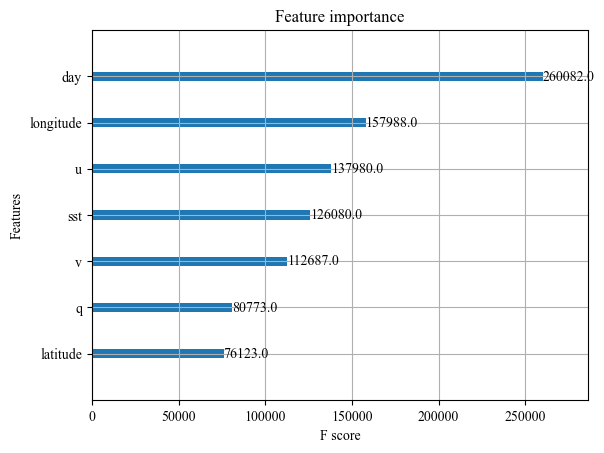

In [22]:
plot_importance(xgb_model)
plt.show()

In [23]:
def tuning_function(alg, param_test, training_X, training_y):
    """
    Tune the hyperparameters of the model
    
    Parameters:
    -----------
    alg: xgboost model
        The xgboost model to be trained
    param_test: dict
        The hyperparameters to be tuned
    training_X: pd dataframe
        The training data
    training_y: pd dataframe
        The training label
    
    return: dict
        The best hyperparameters
    """
    gsearch = GridSearchCV(estimator = alg, 
                           param_grid = param_test, 
                           scoring='neg_mean_squared_error', 
                           n_jobs=-1,
                           verbose=1,
                           cv=4)
    
    gsearch.fit(training_X, training_y)

    print("Best parameters found: ", gsearch.best_params_)
    print("Lowest RMSE found: ", np.sqrt(np.abs(gsearch.best_score_)))

    new_params = alg.get_xgb_params()
    for key in gsearch.best_params_.keys():
        new_params[key] = gsearch.best_params_[key]

    alg = xgb.XGBRegressor(**new_params)

    return alg, gsearch.cv_results_

In [24]:
def plot_gridsearch(grid, results, folds=4):

    x = np.arange(0,len(results['params']))

    fig = plt.figure(figsize=(16,4))
    ax = plt.subplot(111)
    cols=sns.color_palette("cubehelix",folds)

    for i in range(4):  

        plt.scatter(x=x,y=results['split{}_test_score'.format(i)],
                        color=cols[i],edgecolor='grey',s=50,
                        alpha=0.5,label='Fold {}'.format(i+1))
        plt.plot(x,results['split{}_test_score'.format(i)],
                 color=cols[i])

    plt.scatter(x=x,y=results['mean_test_score'],
                    color='black',edgecolor='grey',s=50,
                    alpha=0.5,label='Mean')
    plt.plot(x,results['mean_test_score'],
             color='black')

    plt.ylabel('RMSE')

    k = list(results['params'][0].keys())
    if len(k) > 1: 
        labels = ['{}:{} \n {}:{}'.format(k[0],
                                            results['params'][i][k[0]],
                                            k[1],
                                            results['params'][i][k[1]],
                                           ) for i in range(len(results['params']))]

        plt.xlabel('Parameters')
        plt.xticks(x, labels,rotation=90)
    else:
        plt.xlabel(k[0])
        plt.xticks(x, grid[k[0]])

    plt.legend()

In [25]:
# gamma
grid_3 = {'gamma': [0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12]}
xgb_reg, results_3 = tuning_function(xgb_reg, grid_3, training_X, training_y)

Fitting 4 folds for each of 7 candidates, totalling 28 fits


/g/data/jk72/yz7014/stf/testvenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:33:05] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/g/data/jk72/yz7014/stf/testvenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:33:06] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordi

Best parameters found:  {'gamma': 0}
Lowest RMSE found:  0.00800348718063753


In [26]:
results_3

{'mean_fit_time': array([314.93537372, 142.62809211, 126.62135684, 106.09691846,
         98.93800992,  90.12060946,  83.80144507]),
 'std_fit_time': array([0.27276548, 1.49141076, 1.01605371, 1.09772795, 0.940544  ,
        0.73635462, 0.62976179]),
 'mean_score_time': array([1.76698303, 0.83339947, 0.76238686, 0.81345373, 0.73340791,
        0.60302228, 0.5989722 ]),
 'std_score_time': array([0.15796262, 0.0286795 , 0.0237291 , 0.07382659, 0.03827131,
        0.01551575, 0.04872954]),
 'param_gamma': masked_array(data=[0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12],
              mask=[False, False, False, False, False, False, False],
        fill_value=1e+20),
 'params': [{'gamma': 0},
  {'gamma': 0.02},
  {'gamma': 0.04},
  {'gamma': 0.06},
  {'gamma': 0.08},
  {'gamma': 0.1},
  {'gamma': 0.12}],
 'split0_test_score': array([-4.94345461e-05, -5.03593294e-05, -5.09955978e-05, -5.15322102e-05,
        -5.19895703e-05, -5.23277017e-05, -5.26869254e-05]),
 'split1_test_score': array([-5.70064

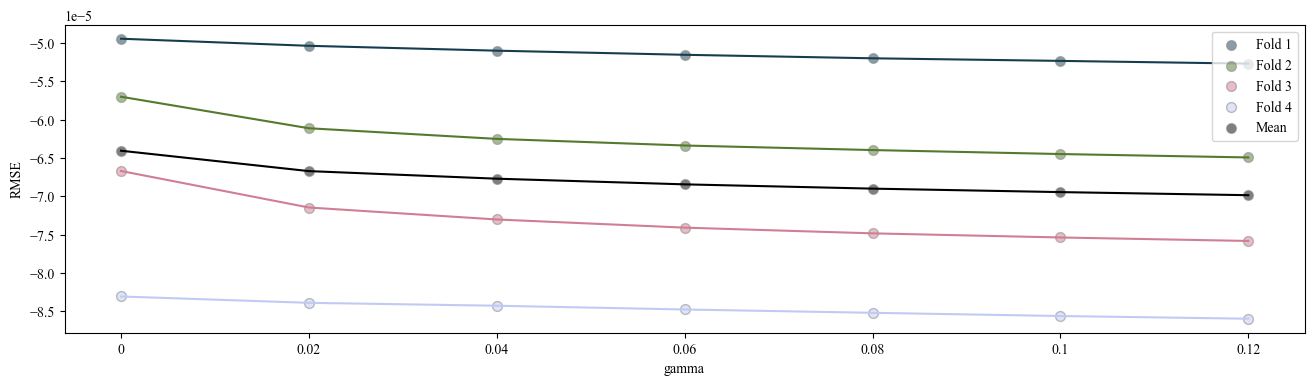

In [27]:
plot_gridsearch(grid_3, results_3)

In [41]:
# gamma
grid_4 = {'gamma': [0.012, 0.016, 0.02, 0.024, 0.028, 0.032]}
xgb_reg, results_4 = tuning_function(xgb_reg, grid_4, training_X, training_y)

Fitting 4 folds for each of 6 candidates, totalling 24 fits
Best parameters found:  {'gamma': 0.012}
Lowest RMSE found:  0.008404795626354284


In [42]:
results_4

{'mean_fit_time': array([40.9453578 , 40.63449168, 39.23960674, 33.34767425, 33.75369602,
        33.17804605]),
 'std_fit_time': array([0.33102319, 0.17049887, 0.37438721, 0.56874038, 0.18388185,
        0.22664732]),
 'mean_score_time': array([0.50311178, 0.47435862, 0.51525676, 0.49264568, 0.4499768 ,
        0.45138425]),
 'std_score_time': array([0.02035873, 0.01191628, 0.01468839, 0.02913624, 0.00818173,
        0.00471806]),
 'param_gamma': masked_array(data=[0.012, 0.016, 0.02, 0.024, 0.028, 0.032],
              mask=[False, False, False, False, False, False],
        fill_value=1e+20),
 'params': [{'gamma': 0.012},
  {'gamma': 0.016},
  {'gamma': 0.02},
  {'gamma': 0.024},
  {'gamma': 0.028},
  {'gamma': 0.032}],
 'split0_test_score': array([-5.05928591e-05, -5.07014349e-05, -5.08766468e-05, -5.09228846e-05,
        -5.10374052e-05, -5.11034559e-05]),
 'split1_test_score': array([-6.48601790e-05, -6.51384519e-05, -6.53830271e-05, -6.56966402e-05,
        -6.58963476e-05, -6.6

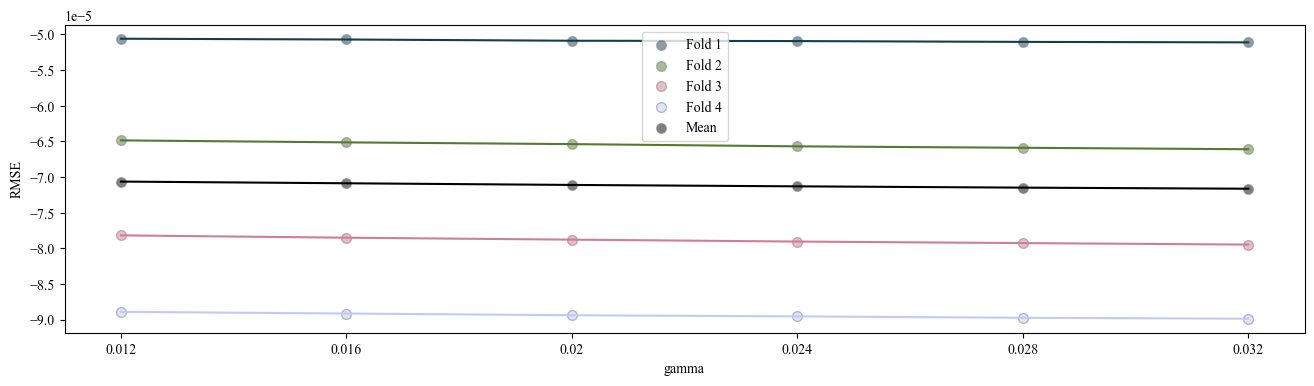

In [43]:
plot_gridsearch(grid_4, results_4)

In [ ]:
xgb.plot_tree(xgb_model, num_trees=0)
plt.rcParams['figure.figsize'] = [50,10]
plt.show()